<a href="https://colab.research.google.com/github/Cimbir/Store-Sales-Forecasting/blob/main/model_sarima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!mkdir ~/.kaggle
!echo "{\"username\":\"dachisuramelashvili\",\"key\":\"4202ec60e20b612a9947450bb8aeebb5\"}" > ~/.kaggle
!cp /content/drive/MyDrive/ML/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists
/bin/bash: line 1: /root/.kaggle: Is a directory


In [3]:
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting
!unzip walmart-recruiting-store-sales-forecasting.zip

walmart-recruiting-store-sales-forecasting.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  walmart-recruiting-store-sales-forecasting.zip
replace features.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace sampleSubmission.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace stores.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [27]:
!unzip train.csv.zip
!unzip stores.csv.zip
!unzip features.csv.zip
!unzip test.csv.zip

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
unzip:  cannot find or open stores.csv.zip, stores.csv.zip.zip or stores.csv.zip.ZIP.
Archive:  features.csv.zip
replace features.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  test.csv.zip
  inflating: test.csv                


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

# Get Data

In [6]:
train = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')

In [7]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [8]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [9]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [10]:
df = pd.merge(train, features, on=['Store', 'Date'], how='left')
df = pd.merge(df, stores, on='Store', how='left')
df = df.drop('IsHoliday_y', axis=1)

display(df.head())

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


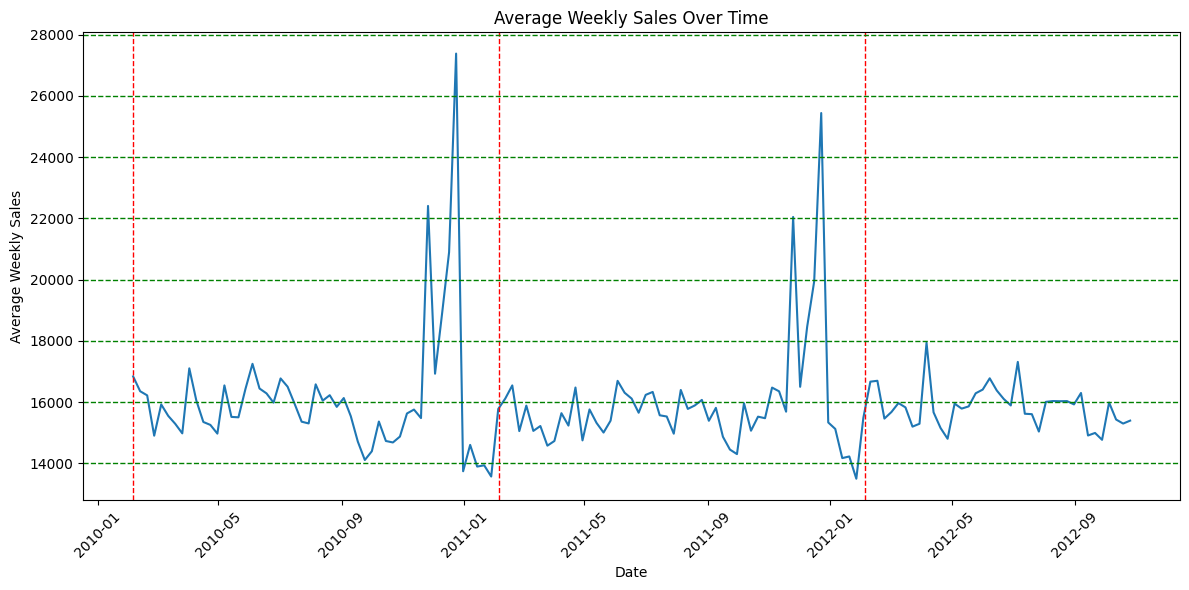

In [11]:
df['Date'] = pd.to_datetime(df['Date'])
avg_sales_over_time = df.groupby('Date')['Weekly_Sales'].mean()

plt.figure(figsize=(12, 6))
plt.plot(avg_sales_over_time.index, avg_sales_over_time.values)
plt.xlabel('Date')
plt.ylabel('Average Weekly Sales')
plt.title('Average Weekly Sales Over Time')
plt.xticks(rotation=45)
plt.tight_layout()

# Add vertical lines for the end of each year
years = pd.to_datetime(avg_sales_over_time.index).year.unique()
for year in years:
    end_of_year = pd.to_datetime(f'{year}-02-05')
    plt.axvline(end_of_year, color='red', linestyle='--', lw=1)

for i in range(7, 15):
  plt.axhline(i * 2000, color='green', linestyle='--', lw=1)

plt.show()

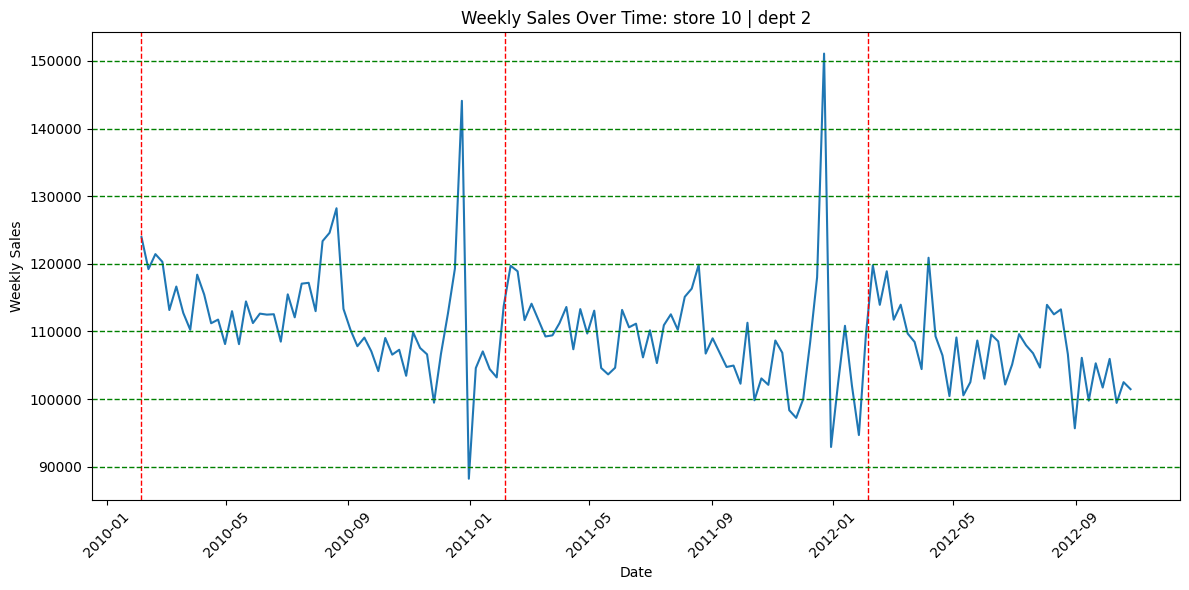

In [115]:
store_id = 10
dept_id = 2

df['Date'] = pd.to_datetime(df['Date'])
store_dept_df = df[(df['Store'] == store_id) & (df['Dept'] == dept_id)]
store_sales_over_time = store_dept_df.groupby('Date')['Weekly_Sales'].sum()

plt.figure(figsize=(12, 6))
plt.plot(store_sales_over_time.index, store_sales_over_time.values)
plt.xlabel('Date')
plt.ylabel(f'Weekly Sales')
plt.title(f'Weekly Sales Over Time: store {store_id} | dept {dept_id}')
plt.xticks(rotation=45)
plt.tight_layout()

# Add vertical lines for the end of each year
years = pd.to_datetime(store_sales_over_time.index).year.unique()
for year in years:
    end_of_year = pd.to_datetime(f'{year}-02-05')
    plt.axvline(end_of_year, color='red', linestyle='--', lw=1)

for i in range(9, 16):
  plt.axhline(i * 10000, color='green', linestyle='--', lw=1)

plt.show()

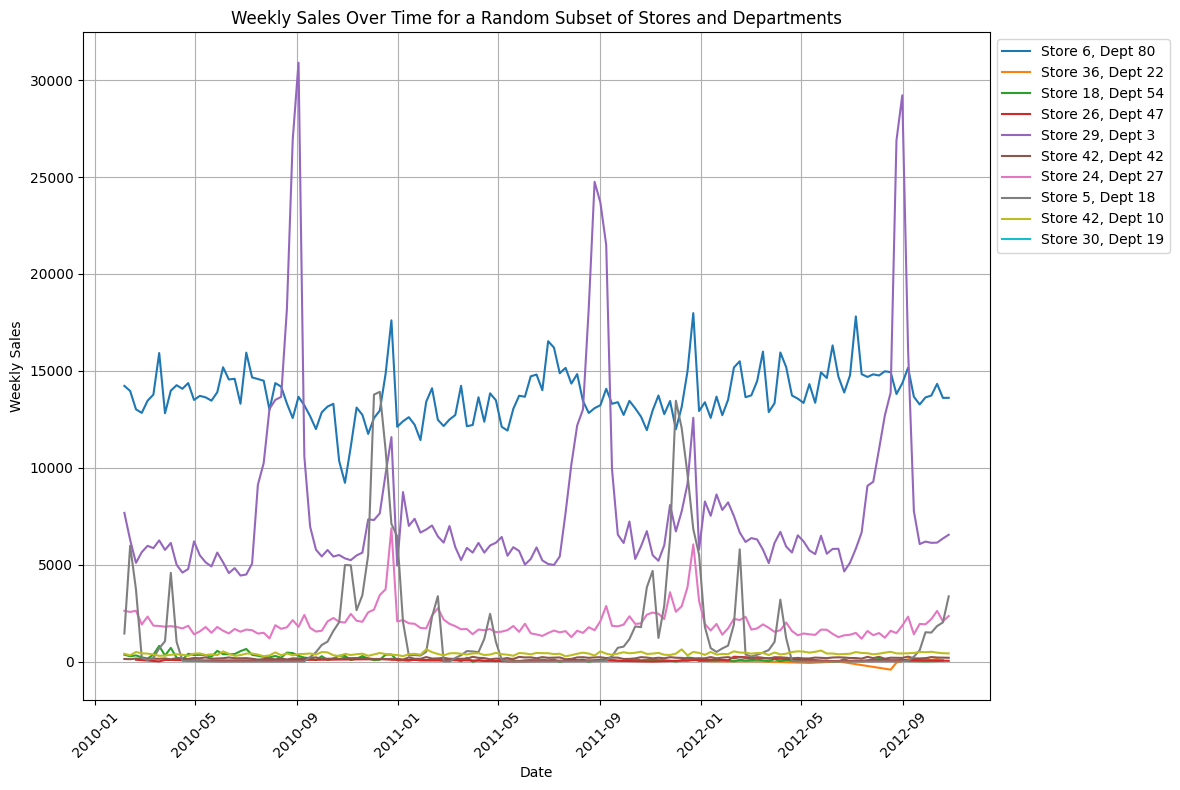

In [116]:
import random

# Get all unique store and department combinations
unique_store_dept = df[['Store', 'Dept']].drop_duplicates()

# Select a random subset of store and department combinations
subset_size = 10  # You can adjust the size of the subset
random_subset_store_dept = unique_store_dept.sample(n=subset_size, random_state=42) # Using random_state for reproducibility

plt.figure(figsize=(14, 8))

for index, row in random_subset_store_dept.iterrows():
    store_id = row['Store']
    dept_id = row['Dept']

    # Filter data for the current store and department
    store_dept_df = df[(df['Store'] == store_id) & (df['Dept'] == dept_id)]

    # Sort by date for proper plotting
    store_dept_df = store_dept_df.sort_values('Date')

    plt.plot(store_dept_df['Date'], store_dept_df['Weekly_Sales'], label=f'Store {store_id}, Dept {dept_id}')

plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales Over Time for a Random Subset of Stores and Departments')
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make room for legend
plt.grid(True)
plt.show()

# Remove Trend

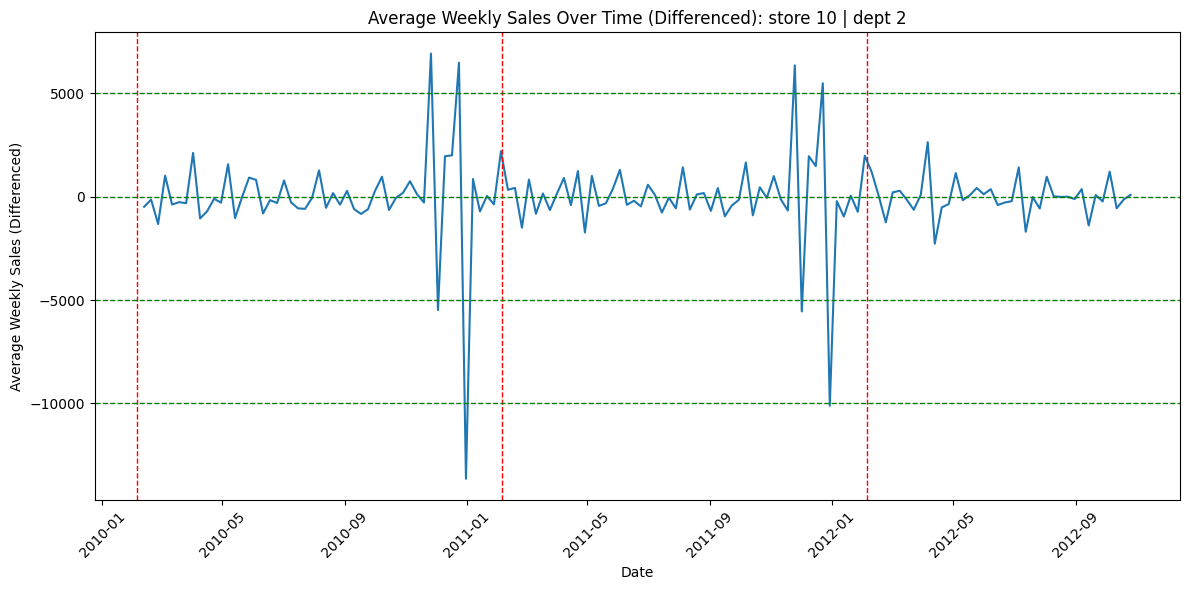

In [13]:
avg_sales_over_time_diff = avg_sales_over_time.diff().dropna()

plt.figure(figsize=(12, 6))
plt.plot(avg_sales_over_time_diff.index, avg_sales_over_time_diff.values)
plt.xlabel('Date')
plt.ylabel(f'Average Weekly Sales (Differenced)')
plt.title(f'Average Weekly Sales Over Time (Differenced): store {store_id} | dept {dept_id}')
plt.xticks(rotation=45)
plt.tight_layout()

# Add vertical lines for the end of each year
years = pd.to_datetime(avg_sales_over_time_diff.index).year.unique()
for year in years:
    end_of_year = pd.to_datetime(f'{year}-02-05')
    plt.axvline(end_of_year, color='red', linestyle='--', lw=1)

for i in range(-2, 2):
  plt.axhline(i * 5000, color='green', linestyle='--', lw=1)

plt.show()

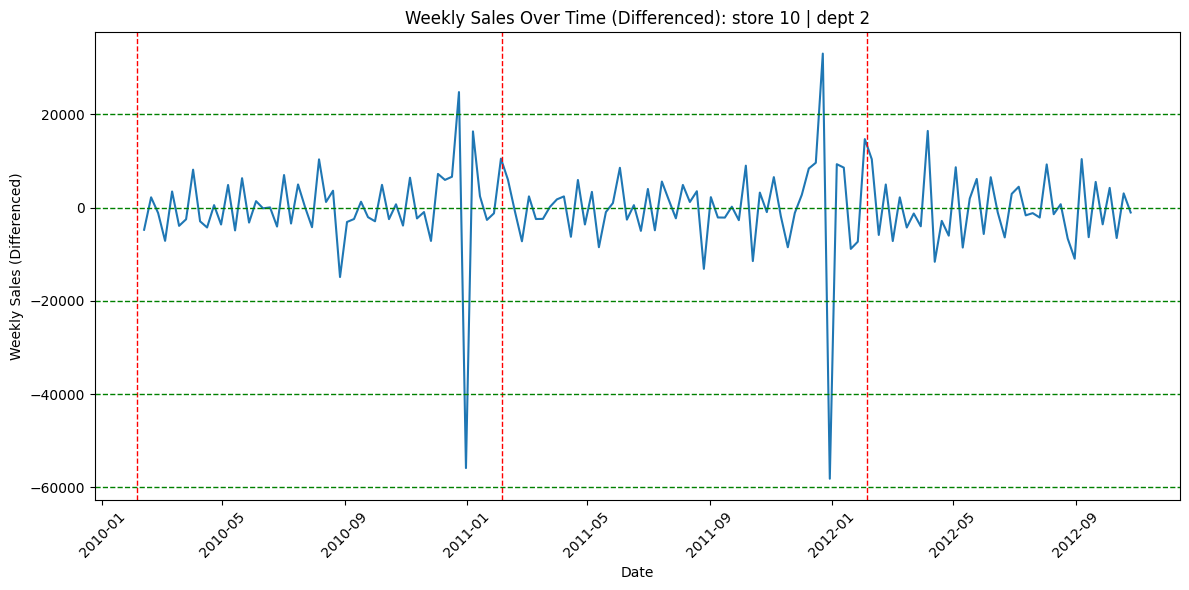

In [14]:
store_id = 10
dept_id = 2

store_dept_df = df[(df['Store'] == store_id) & (df['Dept'] == dept_id)]
store_sales_over_time = store_dept_df.groupby('Date')['Weekly_Sales'].sum()
store_sales_over_time_diff = store_sales_over_time.diff().dropna()

plt.figure(figsize=(12, 6))
plt.plot(store_sales_over_time_diff.index, store_sales_over_time_diff.values)
plt.xlabel('Date')
plt.ylabel(f'Weekly Sales (Differenced)')
plt.title(f'Weekly Sales Over Time (Differenced): store {store_id} | dept {dept_id}')
plt.xticks(rotation=45)
plt.tight_layout()

# Add vertical lines for the end of each year
years = pd.to_datetime(store_sales_over_time_diff.index).year.unique()
for year in years:
    end_of_year = pd.to_datetime(f'{year}-02-05')
    plt.axvline(end_of_year, color='red', linestyle='--', lw=1)

for i in range(-3, 2):
  plt.axhline(i * 20000, color='green', linestyle='--', lw=1)

plt.show()

# ACF

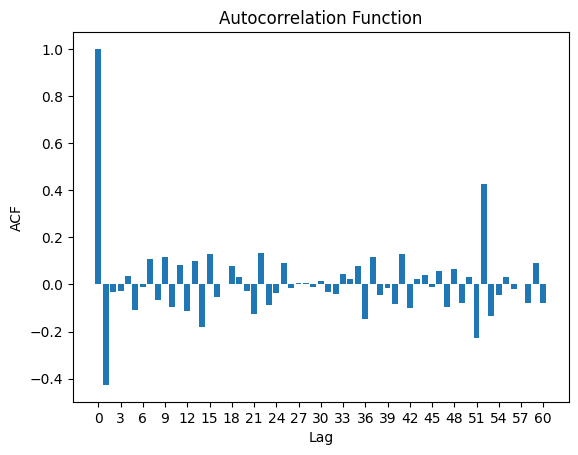

In [15]:
acf_vals = acf(store_sales_over_time_diff, nlags=60)
num_lags = len(acf_vals)
plt.bar(range(num_lags), acf_vals[:num_lags])
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('Autocorrelation Function')
plt.xticks(np.arange(0, num_lags, 3))

plt.show()

# PACF

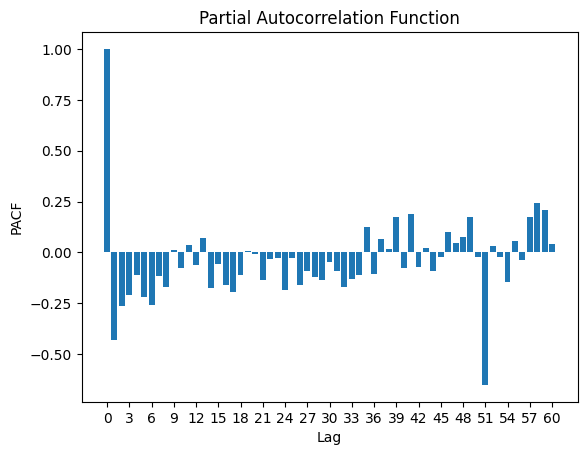

In [16]:
pacf_vals = pacf(store_sales_over_time_diff, nlags=60)
num_lags = len(pacf_vals)
plt.bar(range(num_lags), pacf_vals[:num_lags])
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.title('Partial Autocorrelation Function')
plt.xticks(np.arange(0, num_lags, 3))

plt.show()

# Split


In [56]:
train_end_date = pd.to_datetime('2012-02-03')

df_train = df[df['Date'] < train_end_date]
df_val = df[df['Date'] >= train_end_date]

In [57]:
store_id = 10
dept_id = 2

sd_train_df = df_train[(df_train['Store'] == store_id) & (df_train['Dept'] == dept_id)]
sd_train_df = sd_train_df.set_index('Date')
sd_val_df = df_val[(df_val['Store'] == store_id) & (df_val['Dept'] == dept_id)]
sd_val_df = sd_val_df.set_index('Date')

# Fill NaN

In [64]:
sd_train_df.isnull().sum()

,0
Store,0
Dept,0
Weekly_Sales,0
IsHoliday_x,0
Temperature,0
Fuel_Price,0
MarkDown1,0
MarkDown2,0
MarkDown3,0
MarkDown4,0


In [63]:
sd_val_df.isnull().sum()

,0
Store,0
Dept,0
Weekly_Sales,0
IsHoliday_x,0
Temperature,0
Fuel_Price,0
MarkDown1,0
MarkDown2,0
MarkDown3,0
MarkDown4,0


In [62]:
markdown1_train_mean = sd_train_df['MarkDown1'].mean()
markdown2_train_mean = sd_train_df['MarkDown2'].mean()
markdown3_train_mean = sd_train_df['MarkDown3'].mean()
markdown4_train_mean = sd_train_df['MarkDown4'].mean()
markdown5_train_mean = sd_train_df['MarkDown5'].mean()

sd_train_df['MarkDown1'].fillna(markdown1_train_mean, inplace=True)
sd_train_df['MarkDown2'].fillna(markdown2_train_mean, inplace=True)
sd_train_df['MarkDown3'].fillna(markdown3_train_mean, inplace=True)
sd_train_df['MarkDown4'].fillna(markdown4_train_mean, inplace=True)
sd_train_df['MarkDown5'].fillna(markdown5_train_mean, inplace=True)

sd_val_df['MarkDown1'].fillna(markdown1_train_mean, inplace=True)
sd_val_df['MarkDown2'].fillna(markdown2_train_mean, inplace=True)
sd_val_df['MarkDown3'].fillna(markdown3_train_mean, inplace=True)
sd_val_df['MarkDown4'].fillna(markdown4_train_mean, inplace=True)
sd_val_df['MarkDown5'].fillna(markdown5_train_mean, inplace=True)

# Encode Categorical Variables

In [98]:
sd_train_df['Type'] = sd_train_df['Type'].astype('category').cat.codes
sd_val_df['Type'] = sd_val_df['Type'].astype('category').cat.codes

sd_train_df['IsHoliday_x'] = sd_train_df['IsHoliday_x'].astype(int)
sd_val_df['IsHoliday_x'] = sd_val_df['IsHoliday_x'].astype(int)

display(sd_val_df.dtypes)

,0
Store,int64
Dept,int64
Weekly_Sales,float64
IsHoliday_x,int64
Temperature,float64
Fuel_Price,float64
MarkDown1,float64
MarkDown2,float64
MarkDown3,float64
MarkDown4,float64


In [73]:
sd_train_df

,Store,Dept,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
Date,,,,,,,,,,,,,,,
2010-02-05,10,2,123952.48,False,54.34,2.962,5135.036667,14917.5375,13828.357273,1689.038333,7603.699167,126.442065,9.765,0,126512
2010-02-12,10,2,119209.48,True,49.96,2.828,5135.036667,14917.5375,13828.357273,1689.038333,7603.699167,126.496258,9.765,0,126512
2010-02-19,10,2,121430.80,False,58.22,2.915,5135.036667,14917.5375,13828.357273,1689.038333,7603.699167,126.526286,9.765,0,126512
2010-02-26,10,2,120292.15,False,52.77,2.825,5135.036667,14917.5375,13828.357273,1689.038333,7603.699167,126.552286,9.765,0,126512
2010-03-05,10,2,113163.91,False,55.92,2.877,5135.036667,14917.5375,13828.357273,1689.038333,7603.699167,126.578286,9.765,0,126512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-30,10,2,92906.57,True,48.92,3.428,7676.360000,104519.5400,179.820000,1573.870000,3732.930000,130.071032,7.874,0,126512
2012-01-06,10,2,102234.00,False,59.85,3.443,7737.750000,38456.0900,39.720000,305.200000,5408.080000,130.157516,7.545,0,126512
2012-01-13,10,2,110831.02,False,51.00,3.477,5203.770000,14424.4200,1.380000,597.550000,5659.570000,130.244000,7.545,0,126512


# Fit Model

In [117]:
# Seasonal lag is about 51-52

my_order = (1,1,1)
my_seasonal_order = (1, 1, 1, 51)

# Ensure IsHoliday_x is numerical (boolean is fine for statsmodels) and select exogenous variables
exog_vars_list = ['IsHoliday_x', 'Temperature',	'Fuel_Price',
                  'MarkDown1', 'MarkDown2',	'MarkDown3', 'MarkDown4',	'MarkDown5',
                  'CPI',	'Unemployment',	'Type',	'Size']
exog_vars_train = sd_train_df[exog_vars_list]

model = SARIMAX(
    sd_train_df['Weekly_Sales'],
    exog=exog_vars_train,
    order=my_order,
    seasonal_order=my_seasonal_order
)

In [118]:
start = time()
model_fit = model.fit(method='lbfgs', maxiter=100)
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 49.73918581008911


In [119]:
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  104
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 51)   Log Likelihood                -565.991
Date:                            Thu, 26 Jun 2025   AIC                           1165.983
Time:                                    15:38:12   BIC                           1199.154
Sample:                                02-05-2010   HQIC                          1178.700
                                     - 01-27-2012                                         
Covariance Type:                              opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
IsHoliday_x  -8584.2567   6326.312     -1.357      0.175    -2.1e+04    3815.088
Temperature    353.3500    79

In [121]:
exog_vars_val = sd_val_df[exog_vars_list]
predictions = model_fit.forecast(len(sd_val_df), exog=exog_vars_val)
predictions = pd.Series(predictions, index=sd_val_df.index)
residuals = sd_val_df['Weekly_Sales'].values - predictions.values
residuals = pd.Series(residuals, index=sd_val_df.index)

Text(0, 0.5, 'Error')

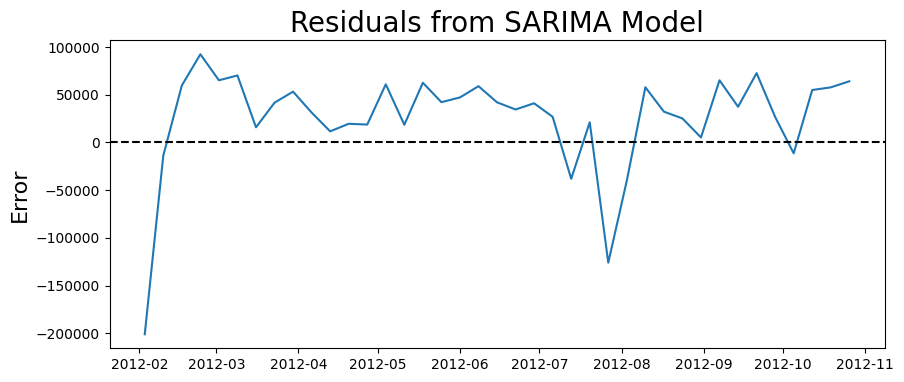

In [122]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

Text(0, 0.5, 'Weekly Sales')

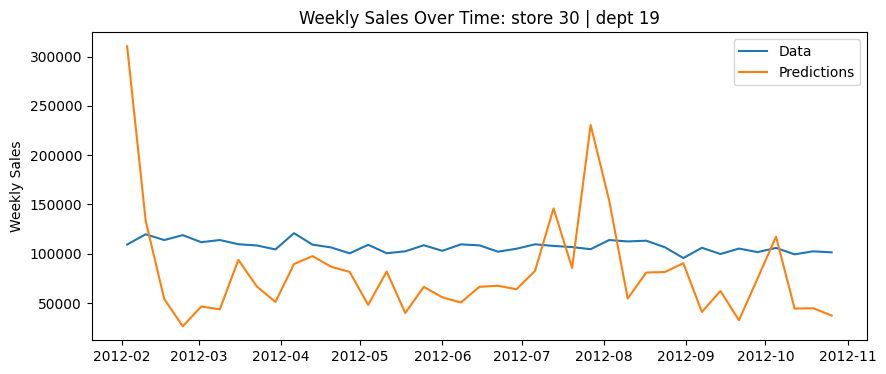

In [123]:
plt.figure(figsize=(10,4))

plt.plot(sd_val_df['Weekly_Sales'])
plt.plot(predictions)

plt.legend(('Data', 'Predictions'))

plt.title(f'Weekly Sales Over Time: store {store_id} | dept {dept_id}')
plt.ylabel('Weekly Sales')